# ID
1.   206204588
2.   316139070


# import

In [ ]:
# !pip install tensorflow
# !pip install keras


In [ ]:
import numpy as np
import os
import tensorflow as tf
import pandas as pd
import cv2
from keras.wrappers.scikit_learn import KerasClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
from tensorflow import keras
from sklearn.model_selection import GridSearchCV
from keras import datasets, layers, models
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve, RocCurveDisplay, confusion_matrix, precision_recall_curve, ConfusionMatrixDisplay, PrecisionRecallDisplay


# **load the data**

In [ ]:
IMG_WIDTH=32
IMG_HEIGHT=30
IMG_FOLDER=r'Data/'

def create_dataset(img_folder):

  img_data_array=[]
  class_name=[]

  for dir1 in os.listdir(img_folder):
    for file in os.listdir(os.path.join(img_folder, dir1)):
        image_path = os.path.join(img_folder, dir1, file)
        image = cv2.imread(image_path, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH),interpolation = cv2.INTER_AREA)
        image = np.array(image)
        image = image.astype('float32')
        image /= 255
        img_data_array.append(image)
        class_name.append(dir1)
  return img_data_array, class_name

# Extract the image array and class name
img_data, class_name = create_dataset(IMG_FOLDER)
target_dict={k: v for v, k in enumerate(np.unique(class_name))}

# Convert the class_names to their respective numeric value based on the dictionary
target_val = [target_dict[class_name[i]] for i in range(len(class_name))]

# Convert to X - a 3d array (samples, width, height) and y - 0/1
X = tf.cast(np.array(img_data), tf.float64)
y = tf.cast(list(map(int,target_val)),tf.int32)

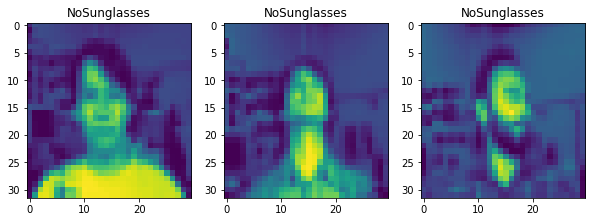

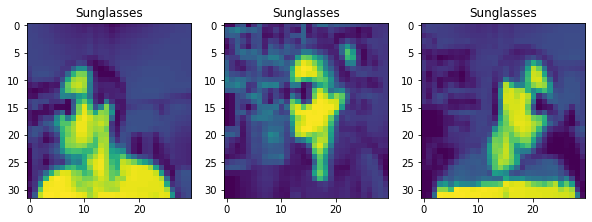

In [ ]:
import matplotlib.pyplot as plt

# Create a dictionary to store the images from each folder
folder_images = {}

# Iterate over the class names
for i, class_name in enumerate(class_name):
    if class_name not in folder_images:
        folder_images[class_name] = []
    folder_images[class_name].append(img_data[i])

# Plot 3 images from each folder
for folder, images in folder_images.items():
    plt.figure(figsize=(10, 10))
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.imshow(images[i])
        plt.title(folder)
    plt.show()


In [ ]:
X = X.numpy()
y = y.numpy()

# **split the data**

In [ ]:
# split the data
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
# validation
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=0)

# **grid search**

First, we will run a grid search in order to find the optimal hyperparameters and after that, we will train the cnn model according the the best hyperparameters.


In [ ]:
def create_model(filters=32, kernel_size=(3,3), activation='relu', optimizer = 'adam'):
    model = Sequential()
    model.add(Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, input_shape=(32, 30, 1)))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Flatten())
    model.add(Dense(units=64, activation='relu'))
    model.add(Dense(units=1, activation='sigmoid'))
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()])
    return model


In [ ]:
# Set up the grid search
param_grid = {'filters': [32, 64],
              'kernel_size': [(3,3), (5,5)],
              'activation': ['relu', 'tanh','sigmoid'],
              "epochs": [15,20],
              "batch_size" : [20,30],
              "optimizer" : ["adam", "sgd"]}
model = KerasClassifier(build_fn=create_model, verbose = 0)
grid_search = GridSearchCV(model, param_grid, cv=3)

# Fit the model
grid_search.fit(x_train, y_train)

# Print the best parameters
print(grid_search.best_params_)

<ipython-input-8-f739d2368fb8>:8: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model, verbose = 0)


{'activation': 'relu', 'batch_size': 20, 'epochs': 20, 'filters': 64, 'kernel_size': (5, 5), 'optimizer': 'adam'}


according to the grid seaech the best parameters to our model : {'activation': 'relu', 'batch_size': 20, 'epochs': 20, 'filters': 64, 'kernel_size': (5, 5), 'optimizer': 'adam'}

# **fit model according to the grid search hyperparameters**

In [ ]:
#{'activation': 'relu', 'batch_size': 30, 'epochs': 20, 'filters': 64, 'kernel_size': (5, 5)}
model = create_model(filters=64, kernel_size=(5,5), activation='relu',optimizer = 'adam')

In [ ]:
# train the model
history = model.fit(x_train, y_train, epochs=20,batch_size=30, validation_data=(x_val, y_val))

Epoch 1/20
15/15 [==============================] - 1s 44ms/step - loss: 0.6844 - accuracy: 0.5323 - precision_291: 0.5288 - recall_291: 0.4955 - val_loss: 0.6541 - val_accuracy: 0.6200 - val_precision_291: 0.6170 - val_recall_291: 0.9667
Epoch 2/20
15/15 [==============================] - 0s 24ms/step - loss: 0.6234 - accuracy: 0.7127 - precision_291: 0.7085 - recall_291: 0.7117 - val_loss: 0.6559 - val_accuracy: 0.5800 - val_precision_291: 0.8462 - val_recall_291: 0.3667
Epoch 3/20
15/15 [==============================] - 0s 24ms/step - loss: 0.5255 - accuracy: 0.7862 - precision_291: 0.8000 - recall_291: 0.7568 - val_loss: 0.5896 - val_accuracy: 0.6400 - val_precision_291: 0.8750 - val_recall_291: 0.4667
Epoch 4/20
15/15 [==============================] - 0s 25ms/step - loss: 0.4683 - accuracy: 0.8174 - precision_291: 0.8365 - recall_291: 0.7838 - val_loss: 0.5070 - val_accuracy: 0.7800 - val_precision_291: 0.7879 - val_recall_291: 0.8667
Epoch 5/20
15/15 [==========================

# **plots of the model**

In [ ]:
def plot_model(metric, val_metric):
  plt.plot(history.history[metric], label="train " + metric)
  plt.plot(history.history[val_metric], label = val_metric)
  plt.xlabel('Epoch')
  plt.ylabel(metric)
  plt.legend(loc='lower right')

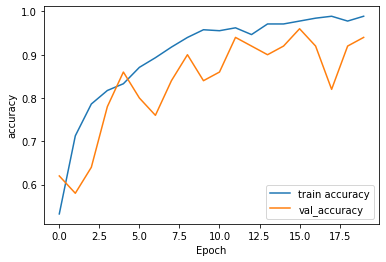

In [ ]:
plot_model("accuracy", "val_accuracy")


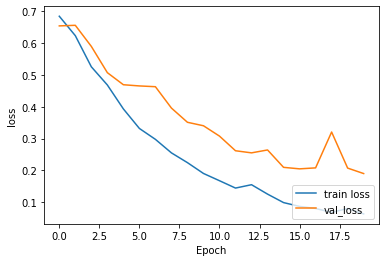

In [ ]:
plot_model("loss", "val_loss")

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'precision_291', 'recall_291', 'val_loss', 'val_accuracy', 'val_precision_291', 'val_recall_291'])

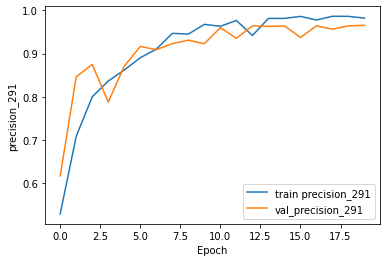

In [ ]:
plot_model("precision_291", "val_precision_291")

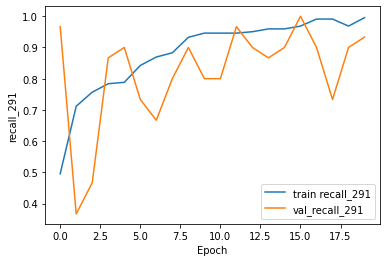

In [ ]:
plot_model("recall_291", "val_recall_291")


# **evaluate the train data**

In [ ]:
print("model train evaluation:")
train_loss, train_accuracy, train_precision, train_recall = model.evaluate(x_train, y_train, verbose=0)
print(f"train loss: {train_loss}")
print(f"train accuracy: {train_accuracy}")
print(f"train precision: {train_precision}")
print(f"train recall: {train_recall}")

model train evaluation:
train loss: 0.04954769089818001
train accuracy: 0.993318498134613
train precision: 0.9910314083099365
train recall: 0.9954954981803894


# **evaluate the test data**

In [ ]:
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(x_test, y_test, verbose=0)
print(f"test loss: {test_loss}")
print(f"test accuracy: {test_accuracy}")
print(f"test precision: {test_precision}")
print(f"test recall: {test_recall}")

test loss: 0.33467379212379456
test accuracy: 0.9200000166893005
test precision: 0.8769230842590332
test recall: 0.9661017060279846


In [ ]:
probabilities_pred = model.predict(x_test)

4/4 [==============================] - 0s 8ms/step


# **confusion matrix**

we represent our model performance using confusion matrix to understand where the model is making errors

Text(33.0, 0.5, 'true label')

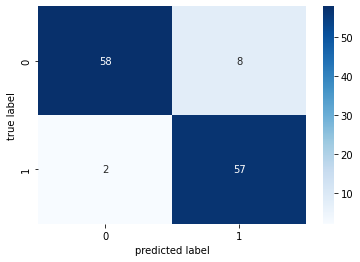

In [ ]:
# confusion matrix

y_pred = []
for pred in probabilities_pred:
  if pred > 0.5:
    y_pred.append(1)
  else:
    y_pred.append(0)

accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues', fmt="d")
plt.xlabel('predicted label')
plt.ylabel('true label')

# **Precision-recall curve**

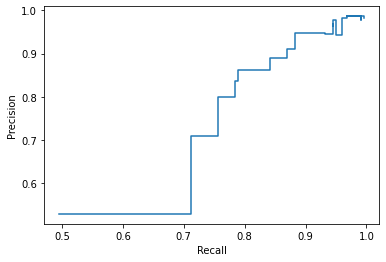

In [ ]:
# Precision-recall curve
precision_recall = PrecisionRecallDisplay(precision=history.history[list(history.history.keys())[2]], recall=history.history[list(history.history.keys())[3]])
precision_recall.plot()



**explanation:** as we have seen in the confusion matrix,in general, the model has very good performance and that is the reason that the curve reaching to the top right corner.

# **roc curve**

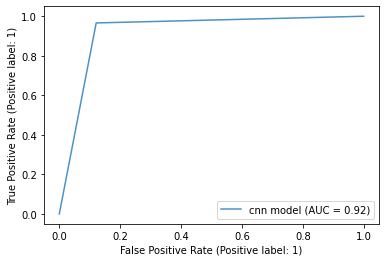

In [ ]:
# roc curve
ax = plt.gca()
roc_curve = RocCurveDisplay.from_predictions(y_test, y_pred, ax=ax, alpha=0.8, name="cnn model")
plt.show()

A ROC curve is a graphical representation of the performance of a binary classification model. It plots the true positive rate (TPR) against the false positive rate (FPR) at various classification thresholds.

the AUC stands for "Area Under the ROC Curve". It is a metric that quantifies the performance of the model by measuring the area under the curve of the ROC plot. we can see that the AUC=0.92 which is a good result.

in addition, our model has good performance and because of that the curve reaches to the top left corner (hogit true positive rate and low false positive rate).



# Does the model overfit?
**the model doesnt overfit**

*   when we look at the trend of the training accuracy and validation accuracy over epochs ,the training accuracy and the validation accuracy are increasing. it may be a sign that our model is not overfitting.

*   when we look at the trend of the training loss and validation loss over epochs, the training loss and the validation loss are consistently decreasing. it may be a sign that our model is not overfitting.

*   there isn't a big difference in the accuracy results for the train and the test set.

# What's the effect of batch size? In general, do you see this effect in the current task?


The batch size is a hyperparameter that determines the number of samples to work through before the model's weights are updated.

A smaller batch size means that the model's parameters will be updated more often, since the weight updates will be based on a smaller subset of the training data. This can make the training process noisier but can also result in the model converging faster, as the model will be exposed to more examples in the same amount of time. However, if the batch size is too small, it can increase the variance of the model.

A larger batch size means that the model's parameters will be updated less often, since the weight updates will be based on a larger subset of the training data. This can make the training process smoother but can also result in the model taking longer to converge, as the model will be exposed to fewer examples in the same amount of time.

in the current task we found the best batch size by using grid search. the batch suze of our model is 20 so we can see the effect of the smaller batch size.

# What was the optimal optimizer? Explain.

according to the grid search results, "adam" was the optimal optimizer.
"adam" is an extension of the stochastic gradient descent (SGD) algorithm.

main possible reasons why "adam" was the optimal optimizer:


*   Adaptive Learning Rate: Adam optimizer uses an adaptive learning rate, which means that it automatically adjusts the learning rate of the model during training. This allows the optimizer to converge faster and with better stability as compared to other optimizers with fixed learning rates.
*   Momentum: Adam optimizer also uses momentum, which means that it takes into account the previous gradients when updating the model's parameters. This helps the optimizer to overcome local minima and converge to the global minimum faster.

more advantages of "adam" optimizer (took from lecture):

* Straightforward to implement.
* Computationally efficient.
* Little memory requirements.
* Invariant to diagonal rescale of the gradients.
* Well suited for problems that are large in terms of data and/or parameters.
* Appropriate for non-stationary objectives.
* Appropriate for problems with very noisy/or sparse gradients.
* Hyper-parameters have intuitive interpretation and typically require little
tuning.

